# Scalable Diffusion Models with Transformer (DiT)

This notebook samples from pre-trained DiT models. DiTs are class-conditional latent diffusion models trained on ImageNet that use transformers in place of U-Nets as the DDPM backbone. DiT outperforms all prior diffusion models on the ImageNet benchmarks.

[Project Page](https://www.wpeebles.com/DiT) | [HuggingFace Space](https://huggingface.co/spaces/wpeebles/DiT) | [Paper](http://arxiv.org/abs/2212.09748) | [GitHub](github.com/facebookresearch/DiT)

In [1]:
# !pip install bitsandbytes

In [2]:
# from diffusers import DiTPipeline, DPMSolverMultistepScheduler
# import torch

# pipe = DiTPipeline.from_pretrained("facebook/DiT-XL-2-256", torch_dtype=torch.float16)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe = pipe.to("cuda")

# # pick words from Imagenet class labels
# pipe.labels  # to print all available words

# # pick words that exist in ImageNet
# words = ["white shark", "umbrella"]

# class_ids = pipe.get_label_ids(words)

# generator = torch.manual_seed(33)
# output = pipe(class_labels=class_ids, num_inference_steps=25, generator=generator)

# image = output.images[0]  # label 'white shark'

# 1. Setup

In [1]:
import os
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
import numpy as np
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")


from utils import TimeCuda, Timer

Using Fused Attention


## Download DiT-XL/2 Models

You can choose between a 512x512 model and a 256x256 model. You can swap-out the LDM VAE, too.

In [2]:
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
## Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
model = model.half()
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

## Analyze the Model

In [4]:
for name, parameter in model.named_parameters():
    print(name, parameter.shape, parameter.shape.numel())
    break

pos_embed torch.Size([1, 256, 1152]) 294912


In [5]:
sum(p.numel() for p in model.blocks[0].parameters())/1e6
for i in model.blocks[0].parameters():
    print(i.shape, i.numel())
    print(torch.min(i), torch.max(i))
    break

torch.Size([3456, 1152]) 3981312
tensor(-1.6675, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.7247, device='cuda:0', grad_fn=<MaxBackward1>)


In [3]:
li=[]
params = []
for name, parameter in model.named_parameters():
    if(parameter.dtype != torch.bfloat16):
        params.append((parameter.detach().cpu().numpy().flatten(), name))
        li.append((np.max(params[-1][0]), np.min(params[-1][0])))

In [4]:
np.max([i[0] for i in li]), np.min([i[1] for i in li])

(11.086, -8.59)

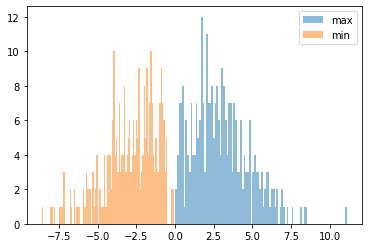

In [5]:
plt.hist([x[0] for x in li], label="max", alpha=0.5, bins=100)
plt.hist([x[1] for x in li], label="min", alpha=0.5, bins=100)
plt.legend()
plt.show()

blocks.0.mlp.fc1.bias
0.234735 -0.5297658


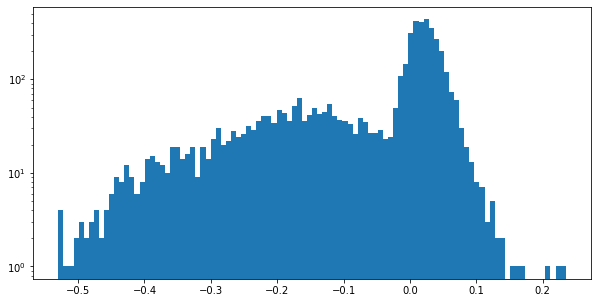

In [ ]:
# plot the parameters of the model

i = 13
param = params[i][0]
print(params[i][1])
print(max(param), min(param))
plt.hist(param, bins=100)
# increase figure size
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.yscale("log")
plt.show()

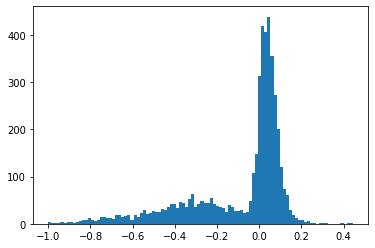

In [ ]:
param_max = param/np.max(abs(param))

plt.hist(param_max, bins=100)
plt.show()

## 2. Sample from Pre-trained DiT Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

  0%|          | 0/50 [00:00<?, ?it/s]

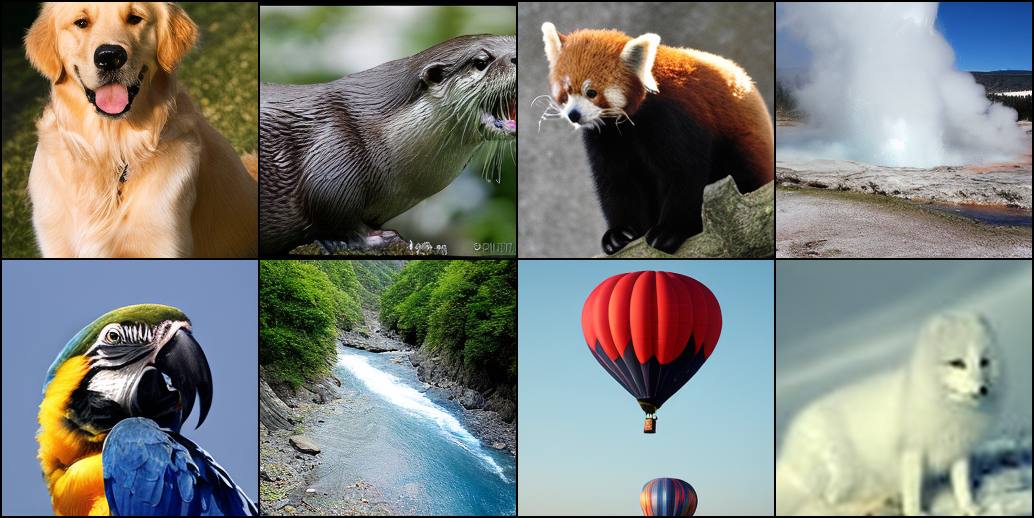

In [4]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 50 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
with torch.no_grad():
    # with TimeCuda("Sampling images..."):
        with torch.autocast(device_type="cuda"):
            samples = diffusion.ddim_sample_loop(
                model.forward_with_cfg, z.shape, z, clip_denoised=False, 
                model_kwargs=model_kwargs, progress=True, device=device
            )
            samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
            samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

## Quant

In [2]:
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8

path = "/home/thunder/my_github_clones/faster-DiT/pretrained_models/DiT-XL-2-256x256.pt"
size = os.path.getsize(path)
print("Size of original file is :", size/1e9, "GB")

vae = AutoencoderKL.from_pretrained(vae_model).to(device)

Size of original file is : 2.700611775 GB


In [3]:
from accelerate import init_empty_weights
from accelerate.utils import BnbQuantizationConfig, load_and_quantize_model
# from mingpt.model import GPT

# model_config = GPT.get_default_config()
# model_config.model_type = 'gpt2-xl'
# model_config.vocab_size = 50257
# model_config.block_size = 1024

with init_empty_weights():
  empty_model = DiT_XL_2(input_size=latent_size)

bnb_quantization_config = BnbQuantizationConfig(
  load_in_4bit=True,
  bnb_4bit_compute_dtype=torch.bfloat16,  # optional
  bnb_4bit_use_double_quant=True,         # optional
  bnb_4bit_quant_type="nf4"               # optional
)

model = load_and_quantize_model(
  empty_model,
  weights_location="/home/thunder/my_github_clones/faster-DiT/pretrained_models/DiT-XL-2-256x256.pt",
  bnb_quantization_config=bnb_quantization_config,
  device_map = "auto"
)

In [12]:
# Check if all layers on the same cuda

for name, parameter in model.named_parameters():
    if parameter.device != torch.device("cuda:0"):
        print(name, parameter.device)

# # print model layers dtype
# for name, parameter in model.named_parameters():
#     print(name, parameter.dtype)

In [13]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 50 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0).to(device)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0).to(device)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
with torch.no_grad():
    # with TimeCuda("Sampling images..."):
        with torch.autocast(device_type="cuda"):
            samples = diffusion.ddim_sample_loop(
                model.forward_with_cfg, z.shape, z, clip_denoised=False, 
                model_kwargs=model_kwargs, progress=True, device=device
            )
            samples, _ = samples.chunk(2, dim=0)  # Remove null class samples

# samples = vae.decode(samples / 0.18215).sample

# # Save and display images:
# save_image(samples, "sample.png", nrow=int(samples_per_row), 
#            normalize=True, value_range=(-1, 1))
# samples = Image.open("sample.png")
# display(samples)

  0%|          | 0/50 [00:00<?, ?it/s]